## Part I: Installation

Assuming that you're reading this in a Jupyter Notebook, that means you've already got Python up-and-running. Our project, Digital Twin for Computational Science (DTCS) is a Python package, but it's not yet on the [Python Package Index (PyPi)](https://pypi.org/) or [Anaconda's Package Index](https://anaconda.org/anaconda/repo), so you need to install it manually.

**If you want to use DTCS on NERSC JupyterLab** , it's highly recommended to create a seperate conda environment with
```
module load python
conda create --name dtcs-3.11 python=3.11
```

And then activate it with
```
conda activate dtcs-3.11
```
If this worked, you should see `(dtcs-3.11)` before your cursor in your shell. Then, you should install the package, with some additional dependencies.
```
pip install git+https://github.com/AndrewBogdan/lbl-crn@demo-fixes
pip install opencv-python Pillow pygame pymatgen gpcam==7.2.5 fvgp==3.2.7
conda install -c anaconda ipykernel
```

Finally, you need to add a kernel specification to your Jupyter notebook interface.

```
python -m ipykernel install --user --name dtcs-3.11 --display-name "DTCS 3.11"
jupyter kernelspec list
```

You should see `DTCS 3.11` in that list of kernels now, and additionally when you go to open a notebook.

**If you want to develop**, you should instead clone the master (default) branch. You can develop from local PC. You're going to want to:
- clone it into a directory (and make it a project with your preferred IDE)
- install it into your `venv` with `pip install -e .`, in the directory (that's the `.`). The `-e` option means it's an editable copy, so when you edit it you don't have to reinstall.
- Get a github token and add it so you can push and pull. If you don't know how to do this, _ask me_ (Andrew), it's painful and complicated and I don't remember how to do it enough to write a guide here, but I've helped so many people do it at this point, so I can get you working in like 15 minutes.

In [1]:
import sys
print(f'Python Version: {sys.version_info.major}.{sys.version_info.minor}')
assert sys.version_info.major == 3, 'Use Python 3.11 or above'
assert sys.version_info.minor >= 3, 'Use Python 3.11 or above'

Python Version: 3.11


In [2]:
import dtcs
print(f'DTCS Version: {dtcs.__version__}')
#assert dtcs.__version__ > '2023.12.14', 'Use a dtcs >= 2023.12.14'

DTCS Version: 2024.5.12dev2


In [3]:
import fvgp
import gpcam

assert gpcam.__version__ == '7.2.5', f'Use gpcam version 7.2.5, not {gpcam.__version__}'
assert fvgp.__version__ <= '3.2.7', f'Use fvgp version <= 3.2.7, not {fvgp.__version__}'

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

## Part II: The Bulk CRN

The Species Manager let us define species by specifying a name, as well as all 'attributes' of this chemical species. 

In the context of bulk CRN, we need name (as a string), binding energy location (as a number), color (as a string in matplotlib named color list), and latex (optional). 

In [6]:
import sympy as sym
from dtcs.spec.xps import XPSSpeciesManager
from dtcs.spec.crn.bulk import CRNSpec, Rxn, RevRxn, Conc, ConcEq, ConcDiffEq, Schedule

# The Species Manager lets us define species by specifying a name, as well as the sort of 'signature' of the species we're defining 
# (in this case, orbital information and binding energies)
sm = XPSSpeciesManager()
h2o_g = sm.make_species('H2O_g', 535.0, color='gray', latex='H_2O_g')
o2_g = sm.make_species('O2_g', 535.0, color='gray', latex='O_{2g}')
h2o = sm.make_species('H2O', 532.2, color='blue', latex='H_2O^*')
oh = sm.make_species('OH', 0, color='red', latex='OH^*') #530.9
o = sm.make_species('O', 0, color='aqua', latex='O^*') #530.0
oh_h2o = sm.make_species('OH-H2O_{hb}', 0, color='black', latex='OH\!-\!H_2O^*') #531.6
o_h2o = sm.make_species('O-H2O_{hb}', 0, color='black', latex='O\!-\!H_2O^*') #531.6
h2o_multi = sm.make_species('multiH2O', 533.2, color='magenta', latex='H_2O_{multi}^*')

# We need to combine the OH in OH and OH-H2O, combine O in O and O-H2O, combine H2O_O and H2O_OH to form H2O_hb
oh_combined = sm.make_species('OH_combined', 530.9, color='red', latex='OH combined^*')
o_combined = sm.make_species('O_combined', 530.0, color='aqua', latex='O combined^*')
h2o_hbond_combined = sm.make_species('H2O_{hb}_combined', 531.6, color='black', latex='H_2O_{hb} combined^*')

sm

Next, we need to define the connectivity between different chemical species, by using key words such as: `Rxn` for reactions,`RevRxn` for reversible reactions or merging two reactions together,`ConcEq` to specify concentrations,`Conc` to specify initial concentrations.


We then call `.simulate` to solve the bulk CRN, which outputs a pandas dataframe of species concentration vs. time evolution. 

In [7]:
crn = CRNSpec(
    Rxn(o + h2o_g, o_h2o, k=3.915042),                  # H2O on O* Adsorption with HB (1)
    Rxn(oh + h2o_g, oh_h2o, k=1.664002),                # H2O on OH* Adsorption with HB (2)
    Rxn(o_h2o, oh + oh, k=6.220646),     # O-H2O react to form 2 OHs (3)
    Rxn(oh + oh, o_h2o, k=0.160755),
    Rxn(oh_h2o, h2o + oh, k=0.299507),                  # OH-H2O Diffusion (4)
    Rxn(o_h2o, h2o + o, k=0.167130),                    # O-H2O Diffusion (5)
    Rxn(h2o, h2o_g, k=0.794455),                        # H2O Desorption, (6)
    Rxn(h2o_g, h2o, k=0.629363),                        # H2O Adsorption, (7)
    Rxn(oh_h2o, oh + h2o_g, k=0.300480),                # H2O on OH* Desorption with HB (8)
    Rxn(o_h2o, o + h2o_g, k=0.127713),                  # H2O on O* Desorption with HB (9)
    Rxn(oh_h2o + h2o_g, h2o_multi, k=1.267427),         # H2O on OH-H2O* Adsorption (10)
    Rxn(h2o_multi, oh_h2o + h2o_g, k=0.394500),         # H2O on OH-H2O* Desorption (11)
    
                                                                 
    ConcEq(oh_combined,oh + oh_h2o),                         
    ConcEq(o_combined,o + o_h2o),
    ConcEq(h2o_hbond_combined,o_h2o + oh_h2o),
    
    Conc(h2o_g, 1),                                     
    Conc(o, 0.25),
    sm,
    time=20,
)

cts = crn.simulate()

In [8]:
crn.rsys.display_dynamics()

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Text(0, 0.5, 'Concentration')

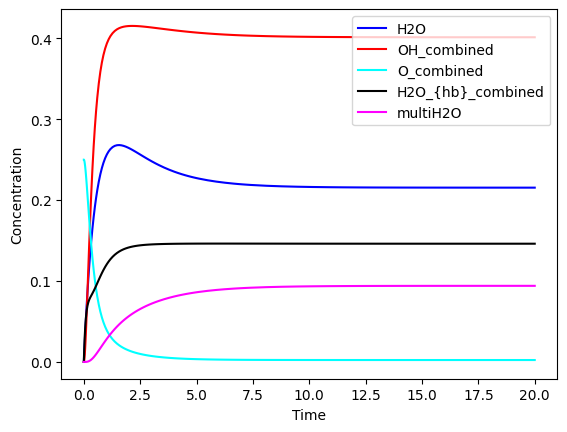

In [9]:
cts.plot(species=[h2o, oh_combined, o_combined, h2o_hbond_combined, h2o_multi])

plt.xlabel('Time')
plt.ylabel('Concentration')

#to convert cts to a pandas dataframe, use command >> cts.df

<Axes: title={'center': 'time=20.0'}>

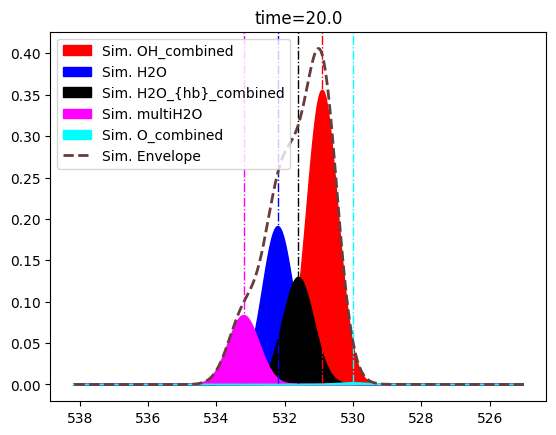

In [10]:
xps = cts.xps_with(species=[h2o, oh_combined, o_combined, h2o_hbond_combined, h2o_multi])
xps.plot()

#use Shift + Tab to see functionalities

## Part III: The Surface CRN

For surface CRN, we need to first generate a 2D map for the chemical species to react on, and we also need another layer of information in species manager, which is the site information.

In [11]:
from pymatgen.core.surface import SlabGenerator, generate_all_slabs, get_symmetrically_distinct_miller_indices
from pymatgen.core import Structure, Lattice
from pymatgen.io.vasp.inputs import Poscar
import warnings

# try: import crystal_toolkit
# except ModuleNotFoundError: warnings.warn('Not using crystal toolkit.')

# Create a silver lattice
lattice = Lattice.cubic(4.086)  # Lattice constant for silver in Angstroms
bulk_structure = Structure(lattice, ['Ag'], [[0, 0, 0]])

# Use a SlabGenerator to create a N x N slab
N = 5

slabgen = SlabGenerator(
    bulk_structure, 
    miller_index=(1, 1, 1), 
    min_slab_size=3,
    min_vacuum_size=2,
    max_normal_search=True,
)
slabs = slabgen.get_slabs()
st = slabs[0] * (N, N, 1)

# Save it as a file, and load it in DTCS

poscar_file = r'Ag-111 Temp.POSCAR'
_ = st.to(fmt="poscar", filename=poscar_file)
# st

from dtcs.spec.crn.surface.surface import Surface
from dtcs.common.display import color_map, latex_map

ag = Surface.from_poscar(
    poscar_file, 
    name='Ag', 
    color='#e1e1e1',
)

# Color and add LaTeX to the surface

def init_specie(name, color=None, latex=None):
    color_map[name] = color
    latex_map[name] = latex
    
init_specie(ag.top, color='silver', latex=r'Ag')
init_specie(ag.threefold, color='silver', latex=r'Ag_{3F}')

In [12]:
from dtcs.spec.species import SpeciesManager
from dtcs.spec.xps import XPSSurfaceSpecies

sm = SpeciesManager(species_cls=XPSSurfaceSpecies)

h2o_surf = sm.sp('H2O*', 532.2, site=ag.top, color='blue', latex=r'H_2{O}^*')
h2o_multi = sm.sp('H2O_multi', 533.2, site=ag.top, size=3, color='magenta', latex=r'H_2O_{multi}^*')
h2o_o_hb = sm.sp('H2O_O_hb', 531.6, site=ag.top, size=2, color='black', latex=r'H_2O–O^*')
h2o_oh_hb = sm.sp('H2O_OH_hb', 531.6, site=ag.top, size=2, color='black', latex=r'H_2O–OH^*')

o_surf = sm.sp('O*', 530.0, site=ag.top, color='aqua', latex=r'O^*')
oh_surf = sm.sp('OH*', 530.9, site=ag.top, color='red', latex=r'OH^*')
o_surf_3f = sm.sp('O*3F', 530.0, site=ag.threefold, color='aqua', latex=r'O^*_{3F}')
oh_surf_3f = sm.sp('OH*3F', 530.9, site=ag.threefold, color='red', latex=r'OH^*_{3F}')

from dtcs.spec.crn.surface.rxn_system import SurfaceRxnSystem
from dtcs.spec.crn.surface.core import SurfaceCRNSpec
from dtcs.spec.crn.surface.conditions import Coverage
from dtcs.spec.crn.surface.reaction import SurfaceRxn, SurfaceRevRxn

scrn = SurfaceCRNSpec(
    
    SurfaceRevRxn([ag.top], [h2o_surf], k=0.629363, k2=0.794455),
    SurfaceRevRxn([o_surf_3f,ag.top], [h2o_o_hb,ag.threefold], k=3.915042, k2=0.127713),
    SurfaceRevRxn([oh_surf_3f,ag.top], [h2o_oh_hb,ag.threefold], k=1.664002, k2=0.300480),
    SurfaceRevRxn([h2o_oh_hb,ag.top], [h2o_multi,ag.top], k=1.267427, k2=0.394500),
    
    SurfaceRevRxn([h2o_o_hb, ag.threefold], [oh_surf, oh_surf_3f], k=6.220646, k2=0.160755),
    
    SurfaceRxn([h2o_oh_hb, ag.threefold], [h2o_surf, oh_surf_3f], k=0.299507),
    SurfaceRxn([h2o_o_hb, ag.threefold], [h2o_surf, o_surf_3f], k=0.167130),
    
    SurfaceRevRxn([oh_surf, ag.threefold], [ag.top, oh_surf_3f], k=2.175, k2=0.457),
    SurfaceRevRxn([o_surf, ag.threefold], [ag.top, o_surf_3f], k=2.175, k2=0.457),  

    SurfaceRxn([ag.threefold, o_surf_3f], [o_surf_3f, ag.threefold], k=1),
    SurfaceRxn([ag.threefold, oh_surf_3f], [oh_surf_3f, ag.threefold], k=1),
    SurfaceRxn([ag.top, o_surf], [o_surf, ag.top], k=1),
    SurfaceRxn([ag.top, oh_surf], [oh_surf, ag.top], k=1),
    SurfaceRxn([ag.top, h2o_surf], [h2o_surf, ag.top], k=1),
    
    Coverage(o_surf_3f, 0.25),
    
    species=sm,
    surface=ag,
    time=20,
    runs=2,
)

In [13]:
scts=scrn.simulate()

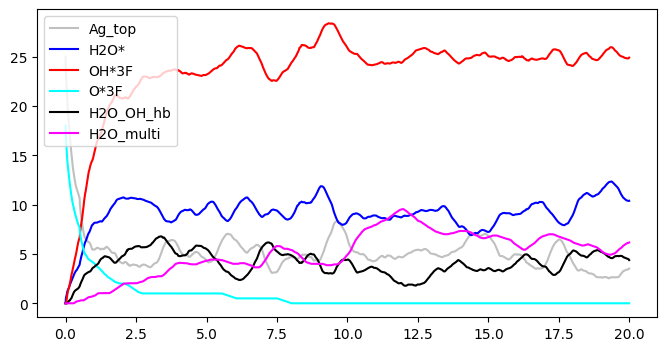

In [14]:
from matplotlib import pyplot as plt

plt.subplots(1, 1, figsize=(8, 4))

scts.plot(species=[ag.top, h2o_surf, oh_surf_3f,o_surf_3f, h2o_oh_hb, h2o_multi])

<Axes: title={'center': 'time=19.990000000000002'}>

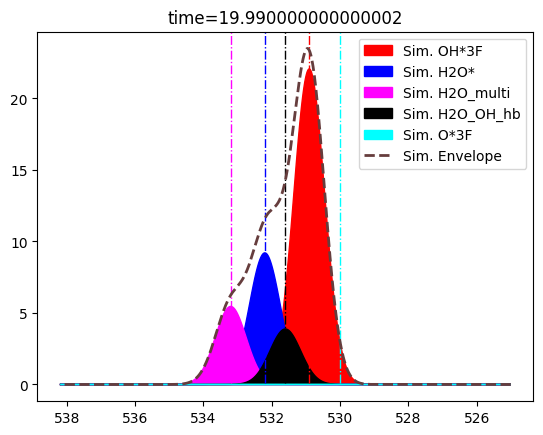

In [15]:
xps = scts.xps_with(species=[h2o_surf, oh_surf_3f,o_surf_3f, h2o_oh_hb, h2o_multi])
xps.plot()

In [16]:
#note: generating the video is going to take a while (~5 mins for this system)
scts.make_video(
    frames_per_timestep=4,
    timeseries_kwargs=dict(ignore=[ag.top, ag.threefold])
)

Wrote to output.mp4


## Part IV: The Inverse Solver - Basin Hopping (BH)

The most challenging, yet most impactful problem in chemistry or materials science concerns solving a problem backwards. For example, given an observed phenomena (i.e., spectra), solve for the CRN that can lead to this spectra. Moreover, even if we are lucky to find a match, how do we know that this is the ONLY solution? This is what I call the degeneracy problem. 

I will walk you through our attempts to address the inverse problem and the degeneracy problem, starting with the lower dimension bulk CRN (already very high in other context, as it contains 12 equations!) then move on higher dimension surface CRN (23 equations!)

To do so, we first define the translational rules for the forward reaction and the backward reaction. For reactions involving adsorbing/desorbing H2O molecule (or any other gas phase molecules in a general sense), we will need to take gas phase entropic correction into consideration.


In [24]:
import sympy as sym
from dtcs.common.const import DG, K, P
from sympy.physics import units
from dtcs.spec.crn.rxn_abc import DG_TO_RATE
from dtcs import config

corrG = 0.219 * config.units['energy'] #in unit of eV, the correction term for gas phase H2O
#corr = 5 * (P / units.torr) * sym.exp(-0.1 * (DG - corrG) / (units.boltzmann * 298.2320872274144 * units.kelvin))
corr = 11.7187 * (P / units.torr) * sym.exp(-0.1 * (DG) / (units.boltzmann * 298.2320872274144 * units.kelvin)) # adsorption
desorption = 0.4281 * sym.exp(-0.1 * (DG) / (units.boltzmann * 298.2320872274144 * units.kelvin)) # desorption
#11.7187 is the convenient way of rewriting the prefactor (prefactor 5 together with the correction factored out)

#FOR IGNORING DEPRECATION WARNINGS

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [25]:
# Copy over the inverse problem from before and testing it out

from dtcs.spec.xps import XPSSpeciesManager
from dtcs.spec.crn.bulk import CRNSpec, Rxn, RevRxn, Conc, ConcEq

# The Species Manager lets us define species by specifying a name, as well as the sort of 'signature' of the species we're defining 
# (in this case, orbital information and binding energies)
sm = XPSSpeciesManager()
h2o_g = sm.make_species('H2O_g', 535.0, color='gray', latex='H_2O_g')
o2_g = sm.make_species('O2_g', 535.0, color='gray', latex='O_{2g}')
h2o = sm.make_species('H2O', 532.2, color='blue', latex='H_2O^*')
oh = sm.make_species('OH', 0, color='red', latex='OH^*') #530.9
o = sm.make_species('O', 0, color='aqua', latex='O^*') #530.0
oh_h2o = sm.make_species('OH-H2O_{hb}', 0, color='black', latex='OH\!-\!H_2O^*') #531.6
o_h2o = sm.make_species('O-H2O_{hb}', 0, color='black', latex='O\!-\!H_2O^*') #531.6
h2o_multi = sm.make_species('multiH2O', 533.2, color='magenta', latex='H_2O_{multi}^*')

# We need to combine the OH in OH and OH-H2O, combine O in O and O-H2O, combine H2O_O and H2O_OH to form H2O_hb
oh_combined = sm.make_species('OH_combined', 530.9, color='red', latex='OH combined^*')
o_combined = sm.make_species('O_combined', 530.0, color='aqua', latex='O combined^*')
h2o_hbond_combined = sm.make_species('H2O_{hb}_combined', 531.6, color='black', latex='H_2O_{hb} combined^*')

crn = CRNSpec(
    RevRxn(o + h2o_g, o_h2o, k=corr, k2=desorption, dg=1),     # H2O on O* Adsorption and Desorption with HB(1)&(9)
    RevRxn(oh + h2o_g, oh_h2o, k=corr, k2=desorption, dg=1),   # H2O on OH* Adsorption and Desorption with HB(2)&(8)
    RevRxn(o_h2o, oh + oh, k='basic',k2='basic', dg=1),        # Reaction (3)
    Rxn(oh_h2o, h2o + oh, k='basic', dg=1),                    # OH-H2O Diffusion (4)
    Rxn(o_h2o, h2o + o, k='basic', dg=1),                      # O-H2O Diffusion (5)
    RevRxn(h2o_g, h2o, k=corr, k2=desorption, dg=1),           # H2O Adsorption, (6)
    RevRxn(oh_h2o + h2o_g, h2o_multi, k=corr, k2=desorption, dg=1),  # H2O on OH-H2O* Adsorption and Desorption (10)&(11) 
#   RevRxn(o + o, o2_g, k='basic', k2="basic",dg=1.82),       # O2 Adsorption and Desoprtion, since we are not varying oxygen 
                                                             
    ConcEq(oh_combined,oh + oh_h2o),
    ConcEq(o_combined,o + o_h2o),
    ConcEq(h2o_hbond_combined,o_h2o + oh_h2o),
    
    Conc(h2o_g, 1),
    Conc(o, 0.25),
    sm,
    time=20
)


In [26]:
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning) 

import os
import pandas as pd
import numpy as np

DATA_PATH = r'/global/cfs/cdirs/m3974/paper/DTCS Manuscript Figure 5'

BINDING_ENERGIES = [533.2, 532.2, 531.6, 530.9, 530.0]

data_filepath = os.path.join(DATA_PATH, 'single_simulated.csv') 
env = pd.read_csv(data_filepath, index_col=0, header=2).squeeze('columns') 

goal = {}    # goal values are the peak heights at the specificed binding energy locations

samples = np.interp(
    x=BINDING_ENERGIES,
    xp=env.index,
    fp=env.values,
)
for index, energy in enumerate(BINDING_ENERGIES):
    goal[energy] = samples[index]

goal = pd.Series(goal)
goal

533.2    0.099669
532.2    0.256164
531.6    0.314287
530.9    0.397438
530.0    0.050585
dtype: float64

In [27]:
dsg_bh = crn.fit_gibbs(
    sample_at_ev=BINDING_ENERGIES,
    num_energies=7,
    times=[20],
    species_for_xps=[h2o, oh_combined, o_combined, h2o_hbond_combined, h2o_multi]
)

dsg_bh.set_goal(goal)
dsg_bh.goal

533.2    0.250780
532.2    0.644537
531.6    0.790782
530.9    1.000000
530.0    0.127278
dtype: float64

In [28]:
dsg_bh.optimize_bh()

Simulating #608
Row Index #-1104618774151411767
Energies: -0.319, -0.579, -0.472, -0.358, 0.905, 0.487, -0.021
Current Best: 3.389267293573488e-12


What we are looking for are:
```
Energies: -0.31, -0.09, -0.47, 0.31, 0.46, 0.16, -0.02
```
Therefore, we can see that despite the scoring indicating a perfect fit, the answers of using 1 spectra are degenerate. 

We can store the BH results by:
```
dsg_bh.df.sort_values(by=['score']).to_csv('bh_1run_results.csv')
```
However, if we are able to use a series of time varient spectra or isothermal (varying pressure) spectra, we will get much better answer.

In [29]:
DATA_PATH = r'/global/cfs/cdirs/m3974/paper/DTCS Manuscript Figure 5'

TIMES = [0.1, 0.25, 0.5, 1, 2.5, 10]
BINDING_ENERGIES = [533.2, 532.2, 531.6, 530.9, 530.0]

data_filepaths = [os.path.join(DATA_PATH, f'{time}s_simulated.csv') for time in TIMES]
envelopes = {f'{time} s': pd.read_csv(data_filepath, index_col=0, header=2).squeeze('columns') 
             for data_filepath, time in zip(data_filepaths, TIMES)}

goal = {}    # goal values are the peak heights at the specificed binding energy locations
for conds, env in envelopes.items():
    samples = np.interp(
        x=BINDING_ENERGIES,
        xp=env.index,
        fp=env.values,
    )
    for index, energy in enumerate(BINDING_ENERGIES):
        goal[(conds, energy)] = samples[index]
    
goal = pd.Series(goal)
goal

0.1 s   533.2    0.004416
        532.2    0.071419
        531.6    0.082210
        530.9    0.080148
        530.0    0.208092
0.25 s  533.2    0.010466
        532.2    0.138623
        531.6    0.154267
        530.9    0.179498
        530.0    0.171245
0.5 s   533.2    0.021738
        532.2    0.209311
        531.6    0.229529
        530.9    0.299381
        530.0    0.123152
1 s     533.2    0.043989
        532.2    0.276787
        531.6    0.303051
        530.9    0.387392
        530.0    0.082839
2.5 s   533.2    0.077435
        532.2    0.289543
        531.6    0.330899
        530.9    0.410371
        530.0    0.058859
10 s    533.2    0.099202
        532.2    0.256885
        531.6    0.314773
        530.9    0.397939
        530.0    0.050678
dtype: float64

In [30]:
dsg_bh = crn.fit_gibbs(
    sample_at_ev=BINDING_ENERGIES,
    num_energies=7,
    times=TIMES,
    pressures=[0.1],
    species_for_xps=[h2o, oh_combined, o_combined, h2o_hbond_combined, h2o_multi]
)
dsg_bh.set_goal(goal)
dsg_bh.goal

0.1 s   533.2    0.021221
        532.2    0.343207
        531.6    0.395064
        530.9    0.385154
        530.0    1.000000
0.25 s  533.2    0.058304
        532.2    0.772281
        531.6    0.859432
        530.9    1.000000
        530.0    0.954018
0.5 s   533.2    0.072611
        532.2    0.699146
        531.6    0.766678
        530.9    1.000000
        530.0    0.411355
1 s     533.2    0.113553
        532.2    0.714490
        531.6    0.782286
        530.9    1.000000
        530.0    0.213838
2.5 s   533.2    0.188696
        532.2    0.705564
        531.6    0.806342
        530.9    1.000000
        530.0    0.143428
10 s    533.2    0.249289
        532.2    0.645538
        531.6    0.791008
        530.9    1.000000
        530.0    0.127351
dtype: float64

In [31]:
dsg_bh.optimize_bh()

Simulating #318
Row Index #5924570987429525847
Energies: -0.375, 0.122, -0.425, 0.282, 0.325, 0.143, -0.117
Current Best: 0.18861499917685545


In [32]:
DATA_PATH = r'/global/cfs/cdirs/m3974/paper/DTCS Manuscript Figure 5'

PRESSURES = [1e-6, 1e-5, 0.005, 0.015, 0.03, 1e-1]
BINDING_ENERGIES = [533.2, 532.2, 531.6, 530.9, 530.0]

data_filepaths = [os.path.join(DATA_PATH, f'{pressure}t_simulated.csv') for pressure in PRESSURES]
envelopes = {f'{pressure} Torr': pd.read_csv(data_filepath, index_col=0, header=2).squeeze('columns') 
             for data_filepath, pressure in zip(data_filepaths, PRESSURES)}

goal = {}    # goal values are the peak heights at the specificed binding energy locations
for conds, env in envelopes.items():
    samples = np.interp(
        x=BINDING_ENERGIES,
        xp=env.index,
        fp=env.values,
    )
    for index, energy in enumerate(BINDING_ENERGIES):
        goal[(conds, energy)] = samples[index]
    
goal = pd.Series(goal)
goal

1e-06 Torr  533.2    6.205947e-07
            532.2    1.437052e-05
            531.6    5.050756e-04
            530.9    3.038571e-02
            530.0    2.213079e-01
1e-05 Torr  533.2    6.222116e-06
            532.2    1.308089e-04
            531.6    1.420383e-03
            530.9    3.312868e-02
            530.0    2.202382e-01
0.005 Torr  533.2    6.851676e-03
            532.2    5.915287e-02
            531.6    1.704850e-01
            530.9    4.080305e-01
            530.0    7.654690e-02
0.015 Torr  533.2    2.622958e-02
            532.2    1.241738e-01
            531.6    2.350474e-01
            530.9    4.360284e-01
            530.0    6.257329e-02
0.03 Torr   533.2    5.014265e-02
            532.2    1.757560e-01
            531.6    2.721185e-01
            530.9    4.285000e-01
            530.0    5.796494e-02
0.1 Torr    533.2    9.966946e-02
            532.2    2.561635e-01
            531.6    3.142867e-01
            530.9    3.974380e-01
            53

In [33]:
dsg_bh = crn.fit_gibbs(
    sample_at_ev=BINDING_ENERGIES,
    num_energies=7,
    pressures=[1e-6, 1e-5, 0.005, 0.015, 0.03, 1e-1],
    species_for_xps=[h2o, oh_combined, o_combined, h2o_hbond_combined, h2o_multi]
)
dsg_bh.set_goal(goal)
dsg_bh.goal

1e-06 Torr  533.2    0.000003
            532.2    0.000065
            531.6    0.002282
            530.9    0.137301
            530.0    1.000000
1e-05 Torr  533.2    0.000028
            532.2    0.000594
            531.6    0.006449
            530.9    0.150422
            530.0    1.000000
0.005 Torr  533.2    0.016792
            532.2    0.144972
            531.6    0.417824
            530.9    1.000000
            530.0    0.187601
0.015 Torr  533.2    0.060156
            532.2    0.284784
            531.6    0.539064
            530.9    1.000000
            530.0    0.143507
0.03 Torr   533.2    0.117019
            532.2    0.410166
            531.6    0.635049
            530.9    1.000000
            530.0    0.135274
0.1 Torr    533.2    0.250780
            532.2    0.644537
            531.6    0.790782
            530.9    1.000000
            530.0    0.127278
dtype: float64

In [34]:
dsg_bh.optimize_bh()

Simulating #146
Row Index #-2721165226017483896
Energies: -0.315, -0.099, -0.518, 0.255, 0.280, 0.164, -0.023
Current Best: 0.0012931804013892937


What we are looking for are:
```
Energies: -0.31, -0.09, -0.47, 0.31, 0.46, 0.16, -0.02
```

## Part V: The Inverse Solver - Gaussian Processing (GP)

In [59]:
from dtcs.spec.xps import XPSSpeciesManager
from dtcs.spec.crn.bulk import CRNSpec, Rxn, RevRxn, Conc, ConcEq

# The Species Manager lets us define species by specifying a name, as well as the sort of 'signature' of the species we're defining 
# (in this case, orbital information and binding energies)
sm = XPSSpeciesManager()
h2o_g = sm.make_species('H2O_g', 535.0, color='gray', latex='H_2O_g')
o2_g = sm.make_species('O2_g', 535.0, color='gray', latex='O_{2g}')
h2o = sm.make_species('H2O', 532.2, color='blue', latex='H_2O^*')
oh = sm.make_species('OH', 0, color='red', latex='OH^*') #530.9
o = sm.make_species('O', 0, color='aqua', latex='O^*') #530.0
oh_h2o = sm.make_species('OH-H2O_{hb}', 0, color='black', latex='OH\!-\!H_2O^*') #531.6
o_h2o = sm.make_species('O-H2O_{hb}', 0, color='black', latex='O\!-\!H_2O^*') #531.6
h2o_multi = sm.make_species('multiH2O', 533.2, color='magenta', latex='H_2O_{multi}^*')

# We need to combine the OH in OH and OH-H2O, combine O in O and O-H2O, combine H2O_O and H2O_OH to form H2O_hb
oh_combined = sm.make_species('OH_combined', 530.9, color='red', latex='OH combined^*')
o_combined = sm.make_species('O_combined', 530.0, color='aqua', latex='O combined^*')
h2o_hbond_combined = sm.make_species('H2O_{hb}_combined', 531.6, color='black', latex='H_2O_{hb} combined^*')

crn = CRNSpec(
    RevRxn(o + h2o_g, o_h2o, k=corr, k2=desorption, dg=1),     # H2O on O* Adsorption and Desorption with HB(1)&(9)
    RevRxn(oh + h2o_g, oh_h2o, k=corr, k2=desorption, dg=1),   # H2O on OH* Adsorption and Desorption with HB(2)&(8)
    RevRxn(o_h2o, oh + oh, k='basic',k2='basic', dg=1),        # Reaction (3)
    Rxn(oh_h2o, h2o + oh, k='basic', dg=1),                    # OH-H2O Diffusion (4)
    Rxn(o_h2o, h2o + o, k='basic', dg=1),                      # O-H2O Diffusion (5)
    RevRxn(h2o_g, h2o, k=corr, k2=desorption, dg=1),           # H2O Adsorption, (6)
    RevRxn(oh_h2o + h2o_g, h2o_multi, k=corr, k2=desorption, dg=1),  # H2O on OH-H2O* Adsorption and Desorption (10)&(11) 
#   RevRxn(o + o, o2_g, k='basic', k2="basic",dg=1.82),       # O2 Adsorption and Desoprtion, since we are not varying oxygen 
                                                             
    ConcEq(oh_combined,oh + oh_h2o),
    ConcEq(o_combined,o + o_h2o),
    ConcEq(h2o_hbond_combined,o_h2o + oh_h2o),
    
    Conc(h2o_g, 1),
    Conc(o, 0.25),
    sm,
    time=20
)

In [64]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning) 

import os
import pandas as pd
import numpy as np

DATA_PATH = r'/global/cfs/cdirs/m3974/paper/DTCS Manuscript Figure 5'

BINDING_ENERGIES = [533.2, 532.2, 531.6, 530.9, 530.0]

data_filepath = os.path.join(DATA_PATH, 'single_simulated.csv') 
env = pd.read_csv(data_filepath, index_col=0, header=2).squeeze('columns') 

goal = {}    # goal values are the peak heights at the specificed binding energy locations

samples = np.interp(
    x=BINDING_ENERGIES,
    xp=env.index,
    fp=env.values,
)
for index, energy in enumerate(BINDING_ENERGIES):
    goal[energy] = samples[index]

goal = pd.Series(goal)
goal

533.2    0.099669
532.2    0.256164
531.6    0.314287
530.9    0.397438
530.0    0.050585
dtype: float64

In [65]:
dsg_gp = crn.fit_gibbs(
    sample_at_ev=BINDING_ENERGIES,
    num_energies=7,
    times=[20],
    species_for_xps=[h2o, oh_combined, o_combined, h2o_hbond_combined, h2o_multi]
)

dsg_gp.set_goal(goal)
dsg_gp.goal

533.2    0.250780
532.2    0.644537
531.6    0.790782
530.9    1.000000
530.0    0.127278
dtype: float64

In [66]:
#Now we need an instrumentation function; input is like some dictionary where ['position'] is the energy tuple
#We should score the tuple using our normal scoring function and then set the ['value'] to the score and then everything should work

def inst_func(argument):

    l = len(argument)
    
    #prefix
    if l < 10:
        for index in argument:
            gibbs = index['position']
            score = dsg_gp.score(*gibbs)
            index['value'] = score
    
    #suffix
    else:
        gibbs = argument[l-1]['position']
        score = dsg_gp.score(*gibbs)
        argument[l-1]['value'] = score
    
    return argument

In [67]:
#Autonomous experimentation

from gpcam.autonomous_experimenter import AutonomousExperimenterGP

hpbounds = [[0.01, 1e5]] + [[0.001, 5000], ] * 7

exp = AutonomousExperimenterGP(
    parameter_bounds=np.array([(-1 , 1)] * 7),
    instrument_func=inst_func,
    hyperparameters=np.ones(8),
    hyperparameter_bounds=hpbounds,
    acq_func='covariance',
    x=[(0, ) * 7],
)

exp.train()
exp.go(
    N=1000,
    acq_func_opt_setting=lambda _: 'global'
)

Simulating #258
Row Index #-95147029434600214
Energies: -0.780, -0.402, 0.989, -0.954, -0.669, 0.949, 0.740
Current Best: 0.46406141467250517
Data received
Checking if data is clean ...
done
Communicating new data to GP
New data communicated via tell()
fvGP data updated
GP data updated
++++++++++++++++++++++++++
|Training ...            |
++++++++++++++++++++++++++
    No training in this round but I am trying to update the hyperparameters
The Autonomous Experimenter is trying to update the hyperparameters.
The autonomous experimenter could not find an instance of asynchronous training. Therefore, no update.
hps:  [29219.81722209  1621.15919146  1071.03496739  3791.23918666
  4756.24696238  2140.46204166   431.20306664  1306.06325584]
++++++++++++++++++++++++++
|Training Done           |
++++++++++++++++++++++++++



iteration:  259
Run Time:  74.46701192855835      seconds
Number of measurements:  259
hps:  [29219.81722209  1621.15919146  1071.03496739  3791.23918666
  4756.24696238  

KeyboardInterrupt: 

2024-05-14 16:05:34,766 - distributed.nanny - ERROR - Worker process died unexpectedly
Process Dask Worker process (from Nanny):
Traceback (most recent call last):
  File "/global/homes/j/jinqian/.conda/envs/dtcs-3.11/lib/python3.11/asyncio/runners.py", line 118, in run
    return self._loop.run_until_complete(task)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/global/homes/j/jinqian/.conda/envs/dtcs-3.11/lib/python3.11/asyncio/base_events.py", line 654, in run_until_complete
    return future.result()
           ^^^^^^^^^^^^^^^
  File "/global/homes/j/jinqian/.conda/envs/dtcs-3.11/lib/python3.11/site-packages/distributed/nanny.py", line 981, in run
    await worker.finished()
  File "/global/homes/j/jinqian/.conda/envs/dtcs-3.11/lib/python3.11/site-packages/distributed/core.py", line 630, in finished
    await self._event_finished.wait()
  File "/global/homes/j/jinqian/.conda/envs/dtcs-3.11/lib/python3.11/asyncio/locks.py", line 213, in wait
    await fut
asyncio.exceptions.